In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
from particles import resampling as rs
import importlib
import sys
sys.path.append('..')

import GaussianODEs as ode
import GaussianAlgorithms as algo
importlib.reload(ode)
importlib.reload(algo)

<module 'GaussianAlgorithms' from '/Users/francescacrucinio/Documents/GradientFlows4Sampling/Gaussians/GaussianAlgorithms.py'>

In [2]:
mu = 20
sigma = 0.1
mu0 = 0
sigma0 = 1

In [3]:
Niter = 10000
gamma = 0.001
N = 1000
X0 = np.random.normal(0, 1, size = N)

In [4]:
lseq_linear = np.arange(Niter+1)/Niter
alpha = 0.01
lseq_exponential = 1-np.exp(-alpha*np.arange(Niter+1))
lseq_optimal = 1-1/(2+np.arange(Niter+1))

delta_linear = (gamma+np.exp(-gamma)-1)/gamma
delta_exponential = (alpha*(np.exp(-gamma)-1)-np.exp(-alpha*gamma)+1)/(1-alpha)
t = np.linspace(0, gamma, 100)
delta_optimal = 1-np.exp(-gamma) - np.exp(-gamma)*(t[1]-t[0])*np.sum(np.exp(t)/(2+t))

In [5]:
mean_eq_twfr, var_eq_twfr, kl_eq_twfr = ode.tempered_wfr_infinite_time(mu0, mu, sigma0, sigma,  Niter, gamma, lseq_linear)

In [6]:
X_tsmc = np.zeros((Niter, N))
W_tsmc = np.zeros((Niter, N))
X_tsmc[0, :] = X0
W_tsmc[0, :] = np.ones(N)/N

X_twfr = np.zeros((Niter, N))
W_twfr = np.zeros((Niter, N))
X_twfr[0, :] = X0
W_twfr[0, :] = np.ones(N)/N
for i in range(1, Niter):
    l = lseq_linear[i]
    noise = np.random.normal(0, 1, size = N)
    # T-SMC
    if(i > 1):
        # resample
        ancestors = rs.resampling('stratified', W_tsmc[i-1, :])
        X_tsmc[i-1, :] = X_tsmc[i-1, ancestors]
    X_tsmc[i, :], _ = algo.tempered_W_move(mu, sigma, X_tsmc[i-1, :], gamma, noise, l)
    W_tsmc[i, :] = algo.SMC_reweigthing(mu, sigma, X_tsmc[i,:], l-lseq_linear[i-1])
    # T-WFR
    if(i > 1):
        # resample
        ancestors = rs.resampling('stratified', W_twfr[i-1, :])
        X_twfr[i-1, :] = X_twfr[i-1, ancestors]
    X_twfr[i, :], gradient_step_twfr = algo.tempered_W_move(mu, sigma, X_twfr[i-1, :], gamma, noise, l)
    W_twfr[i, :] = algo.FR_reweigthing(mu, sigma, X_twfr[i,:], gamma, delta_linear, gradient_step_twfr, W_twfr[i-1,:])

In [7]:
mean_twfr = np.zeros(Niter)
var_twfr = np.zeros(Niter)
kl_twfr = np.zeros(Niter)

mean_tsmc = np.zeros(Niter)
var_tsmc = np.zeros(Niter)
kl_tsmc = np.zeros(Niter)
for i in range(Niter):
    mean_twfr[i] = np.sum(X_twfr[i, :]*W_twfr[i, :])
    var_twfr[i] = np.sum(X_twfr[i, :]**2*W_twfr[i, :]) - mean_twfr[i]**2
    mean_tsmc[i] = np.sum(X_tsmc[i, :]*W_tsmc[i, :])
    var_tsmc[i] = np.sum(X_tsmc[i, :]**2*W_tsmc[i, :]) - mean_tsmc[i]**2
    kl_twfr[i] = ode.KL(mean_twfr[i], var_twfr[i], mu, sigma)
    kl_tsmc[i] = ode.KL(mean_tsmc[i], var_tsmc[i], mu, sigma)

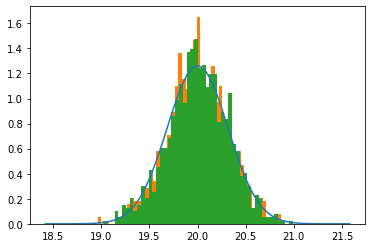

In [8]:
plt.plot(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), norm.pdf(np.linspace(mu-5*np.sqrt(sigma), mu+5*np.sqrt(sigma), 100), scale = np.sqrt(sigma), loc = mu))
plt.hist(X_twfr[-1, :], density = True, weights = W_twfr[-1, :], bins = 50);
plt.hist(X_tsmc[-1, :], density = True, weights = W_tsmc[-1, :], bins = 50);

Text(0, 0.5, 'KL$_t$')

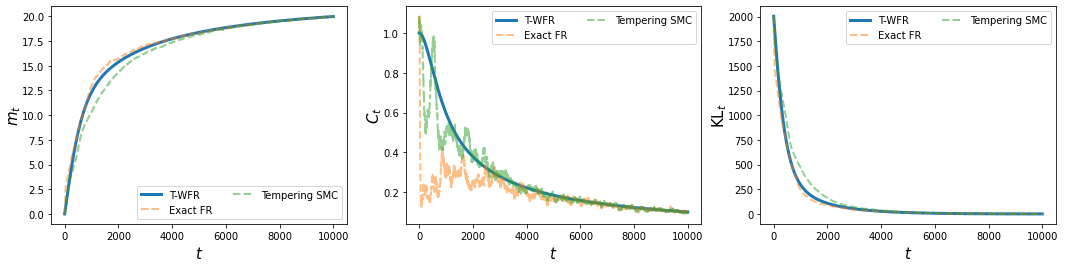

In [9]:
plt.figure(figsize = (18, 4))
# plt.subplot(1, 4, 1)
plt.subplot(1, 3, 1)
plt.plot(np.arange(Niter+1), mean_eq_twfr, label = 'T-WFR', lw = 3)
plt.plot(np.arange(Niter), mean_twfr, label = 'Exact FR', lw = 2, linestyle = 'dashed', alpha = 0.5)
plt.plot(np.arange(Niter), mean_tsmc, label = 'Tempering SMC', lw = 2, linestyle = 'dashed', alpha = 0.5)
plt.xlabel('$t$', fontsize = 15)
plt.ylabel('$m_t$', fontsize = 15, labelpad=-1)
plt.legend(ncol = 2)
# plt.subplot(1, 4, 2)
plt.subplot(1, 3, 2)
plt.plot(np.arange(Niter+1), var_eq_twfr, label = 'T-WFR', lw = 3)
plt.plot(np.arange(Niter), var_twfr, label = 'Exact FR', lw = 2, linestyle = 'dashed', alpha = 0.5)
plt.plot(np.arange(Niter), var_tsmc, label = 'Tempering SMC', lw = 2, linestyle = 'dashed', alpha = 0.5)
plt.legend(ncol = 2)
plt.xlabel('$t$', fontsize = 15)
plt.ylabel('$C_t$', fontsize = 15, labelpad=-1)
plt.subplot(1, 3, 3)
plt.plot(np.arange(Niter+1), kl_eq_twfr, label = 'T-WFR', lw = 3)
plt.plot(np.arange(Niter), kl_twfr, label = 'Exact FR', lw = 2, linestyle = 'dashed', alpha = 0.5)
plt.plot(np.arange(Niter), kl_tsmc, label = 'Tempering SMC', lw = 2, linestyle = 'dashed', alpha = 0.5)
plt.legend(ncol = 2)
plt.xlabel('$t$', fontsize = 15)
plt.ylabel('KL$_t$', fontsize = 15, labelpad=-1)
# plt.savefig('gaussian_tempered_fr_smc_001.pdf', bbox_inches="tight")